In [1]:
from cresset import flare

In [2]:
from rdkit import Chem
from rdkit.Chem import rdFMCS, MCS
from rdkit.Chem.Draw import rdMolDraw2D, IPythonConsole
from rdkit.Chem.rdDepictor import Compute2DCoords
from IPython.display import SVG

`draw_mols` is a simple helper function to draw molecules in a grid using the new C++ code to benefit from atom/bond highlighting when an MCS is supplied as an optional parameter.

In [3]:
def draw_mols(mols, grid=(600, 150, 150, 150), padding=0.15, mcs_res=None):
    d = rdMolDraw2D.MolDraw2DSVG(*grid)
    d.drawOptions().padding = padding
    pmols = [rdMolDraw2D.PrepareMolForDrawing(m) for m in mols]
    [Compute2DCoords(pm) for pm in pmols]
    highlight_atoms = None
    highlight_bonds = None
    if (mcs_res is not None):
        if isinstance(mcs_res, rdFMCS.MCSResult):
            smarts_string = mcs_res.smartsString
        elif isinstance(mcs_res, MCS.MCSResult):
            smarts_string = mcs_res.smarts
        else:
            raise TypeError("mcs_res should be an instance of either "
                            "rdFMCS.MCSResult or MCS.MCSResult")
        mcs_mol = Chem.MolFromSmarts(smarts_string)
        mcs_bonds = [(b.GetBeginAtomIdx(), b.GetEndAtomIdx())
                     for b in mcs_mol.GetBonds()]
        highlight_atoms = []
        highlight_bonds = []
        for m in mols:
            match = m.GetSubstructMatch(mcs_mol)
            highlight_atoms.append(match)
            highlight_bonds.append([m.GetBondBetweenAtoms(
                match[i], match[j]).GetIdx() for i, j in mcs_bonds])
    d.DrawMolecules(pmols, highlightAtoms=highlight_atoms,
                   highlightBonds=highlight_bonds)
    d.FinishDrawing()
    svg = d.GetDrawingText()
    return SVG(svg)

I am sure we all agree on what the MCS between &alpha;-methylnaphthalene and &beta;-aminonaphthalene should be: simply the naphthalene core.

In [4]:
a_methyl_naphthalene = Chem.MolFromSmiles("Cc1cccc2ccccc12")

In [5]:
b_amino_naphthalene = Chem.MolFromSmiles("Nc1ccc2ccccc2c1")

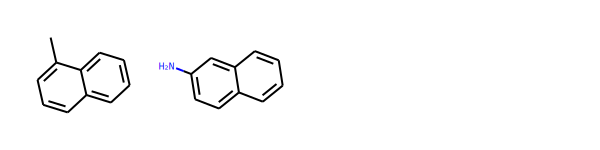

In [6]:
draw_mols((a_methyl_naphthalene, b_amino_naphthalene))

In [7]:
a_methyl_b_amino_naphthalene_res = rdFMCS.FindMCS(
    (a_methyl_naphthalene, b_amino_naphthalene),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [8]:
a_methyl_b_amino_naphthalene_res.numAtoms

10

In [9]:
a_methyl_b_amino_naphthalene_res.numBonds

11

And indeed here it is:

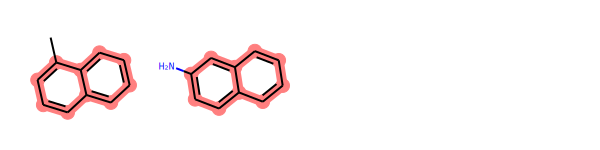

In [10]:
draw_mols((a_methyl_naphthalene, b_amino_naphthalene),
          mcs_res=a_methyl_b_amino_naphthalene_res)

However, I was a bit disappointed to see what the MCS between &alpha;-methylnaphthalene and &beta;-methylnaphthalene is:

In [11]:
b_methyl_naphthalene = Chem.MolFromSmiles("Cc1ccc2ccccc2c1")

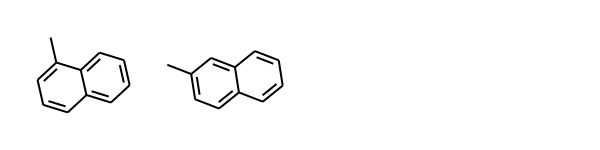

In [12]:
draw_mols((a_methyl_naphthalene, b_methyl_naphthalene))

In [13]:
a_methyl_b_methyl_naphthalene_res = rdFMCS.FindMCS(
    (a_methyl_naphthalene, b_methyl_naphthalene),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [14]:
a_methyl_b_methyl_naphthalene_res.numAtoms

11

In [15]:
a_methyl_b_methyl_naphthalene_res.numBonds

11

The MCS includes the methyl and the cyclodecapentaene crown, without the condensation bond between the two phenyl rings:

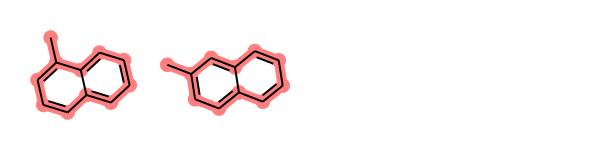

In [16]:
draw_mols((a_methyl_naphthalene, b_methyl_naphthalene),
          mcs_res=a_methyl_b_methyl_naphthalene_res)

While I am not by any means claiming that this is a bug (this is indeed the largest MCS in terms of both atoms and bonds between the two molecules), I believe from a chemist's standpoint it would be more useful to get the same MCS as from &alpha;-methylnaphthalene and &beta;-aminonaphthalene, <i>i.e.</i> the naphthalene core.

In [17]:
a_b_dimethyl_naphthalene = Chem.MolFromSmiles("Cc1c(C)ccc2ccccc12")

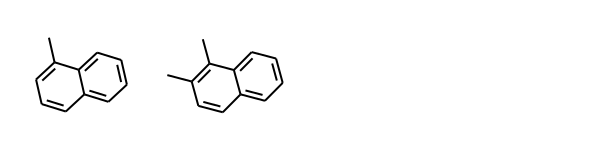

In [18]:
draw_mols((a_methyl_naphthalene, a_b_dimethyl_naphthalene))

In [19]:
a_methyl_a_b_dimethyl_naphthalene_res = rdFMCS.FindMCS(
    (a_methyl_naphthalene, a_b_dimethyl_naphthalene),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [20]:
a_methyl_a_b_dimethyl_naphthalene_res.numAtoms

11

In [21]:
a_methyl_a_b_dimethyl_naphthalene_res.numBonds

12

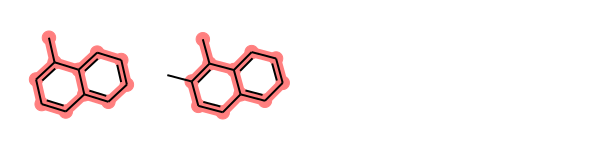

In [22]:
draw_mols((a_methyl_naphthalene, a_b_dimethyl_naphthalene),
          mcs_res=a_methyl_a_b_dimethyl_naphthalene_res)

As expected, the MCS between &alpha;-methylnaphthalene, &beta;-aminonaphthalene and methylciclodecapentaene is methylciclodecapentaene:

In [23]:
cyclodecapentaene = Chem.MolFromSmiles("Cc1ccccccccc1")

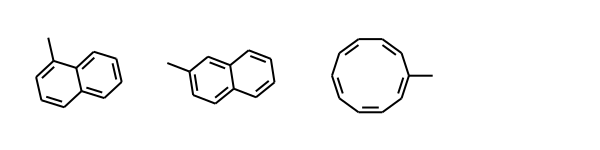

In [24]:
draw_mols((a_methyl_naphthalene, b_methyl_naphthalene, cyclodecapentaene))

In [25]:
amn_bmn_cdp_res = rdFMCS.FindMCS(
    (a_methyl_naphthalene, b_methyl_naphthalene, cyclodecapentaene),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [26]:
amn_bmn_cdp_res.numAtoms

11

In [27]:
amn_bmn_cdp_res.numBonds

11

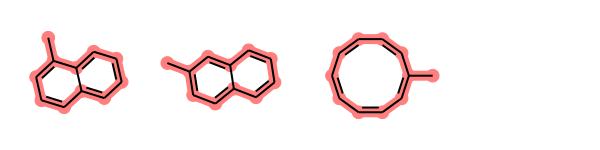

In [28]:
draw_mols((a_methyl_naphthalene, b_methyl_naphthalene, cyclodecapentaene),
          mcs_res=amn_bmn_cdp_res)

Another example that illustrates the current behavior:

In [29]:
a_methyl_bcn = Chem.MolFromSmiles("CC1CCCC2CCCC12")

In [30]:
b_methyl_bcn = Chem.MolFromSmiles("C1C(C)CCC2CCCC12")

In [31]:
a_methyl_tcd = Chem.MolFromSmiles("CC1CCCC(C3)2CCCC123")

In [32]:
b_methyl_tcd = Chem.MolFromSmiles("C1C(C)CCC(C3)2CCCC123")

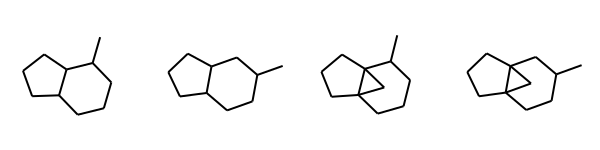

In [33]:
draw_mols((a_methyl_bcn, b_methyl_bcn, a_methyl_tcd, b_methyl_tcd))

In [34]:
a_b_bcn_a_b_tcd_res = rdFMCS.FindMCS(
    (a_methyl_bcn, b_methyl_bcn, a_methyl_tcd, b_methyl_tcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [35]:
a_b_bcn_a_b_tcd_res.numAtoms

10

In [36]:
a_b_bcn_a_b_tcd_res.numBonds

10

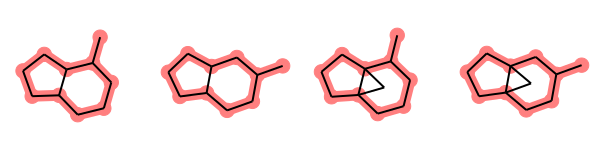

In [37]:
draw_mols((a_methyl_bcn, b_methyl_bcn, a_methyl_tcd, b_methyl_tcd),
          mcs_res=a_b_bcn_a_b_tcd_res)

As expected, when I put the methyl group in position 2 on both systems also the condensation bond is included in the MCS:

In [38]:
a_bcn_a_tcd_res = rdFMCS.FindMCS(
    (a_methyl_bcn, a_methyl_tcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [39]:
a_bcn_a_tcd_res.numAtoms

10

In [40]:
a_bcn_a_tcd_res.numBonds

11

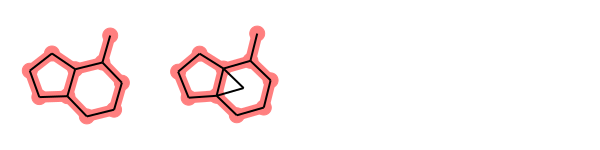

In [41]:
draw_mols((a_methyl_bcn, a_methyl_tcd), padding=0.3,
          mcs_res=a_bcn_a_tcd_res)

In [42]:
a_methyl_bch = Chem.MolFromSmiles("CC1CCC2CC12")

In [43]:
b_methyl_bch = Chem.MolFromSmiles("C1C(C)CC2CC12")

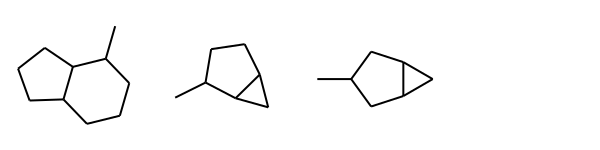

In [44]:
draw_mols((a_methyl_bcn, a_methyl_bch, b_methyl_bch))

Again, even though the MCS would be constituted by only 5 atoms and 5 bonds, I would prefer to see cyclopentane as the MCS between these two structures rather than methylcyclohexane:

In [45]:
a_bcn_a_bch_res = rdFMCS.FindMCS(
    (a_methyl_bcn, a_methyl_bch),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [46]:
a_bcn_a_bch_res.numAtoms

7

In [47]:
a_bcn_a_bch_res.numBonds

7

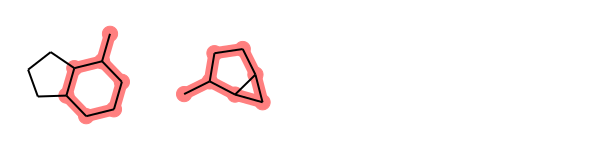

In [48]:
draw_mols((a_methyl_bcn, a_methyl_bch), padding=0.3,
          mcs_res=a_bcn_a_bch_res)

In [49]:
a_bcn_a_bch_res.smartsString

'[#6]-[#6]1-[#6]-[#6]-[#6]-[#6]-[#6]-1'

To my surprise, when I computed the MCS between 2-methylbicyclo[4.3.0]nonane and 3-methylbicyclo[3.1.0]hexane (gosh, I hope I am getting nomenclature right, this is bringing me straight back to my Organic Chemistry I classes), I got a match between ring and non-ring atoms, even though I specified `ringMatchesRingOnly=True`:

In [50]:
a_bcn_b_bch_res = rdFMCS.FindMCS(
    (a_methyl_bcn, b_methyl_bch),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [51]:
a_bcn_b_bch_res.numAtoms

7

In [52]:
a_bcn_b_bch_res.numBonds

7

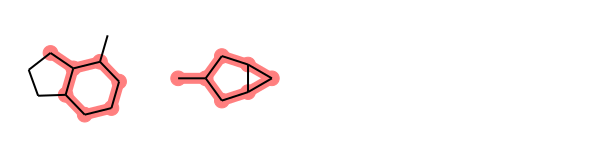

In [53]:
draw_mols((a_methyl_bcn, b_methyl_bch), padding=0.3,
          mcs_res=a_bcn_b_bch_res)

This is caused by the fact that the MCS `smartString` does not contain any ring/non-ring specifiers on bonds:

In [54]:
a_bcn_b_bch_res.smartsString

'[#6]1-[#6](-[#6])-[#6]-[#6]-[#6]-[#6]-1'

However, Andrew Dalke's original MCS implementation did include  ring/non-ring specifiers on bonds:

In [55]:
a_bcn_b_bch_res_legacy = MCS.FindMCS(
    (a_methyl_bcn, b_methyl_bch),
    ringMatchesRingOnly=True, completeRingsOnly=True)

__main__:3: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.


In [56]:
a_bcn_b_bch_res_legacy.numAtoms

7

In [57]:
a_bcn_b_bch_res_legacy.numBonds

7

All bonds are properly labeled:

In [58]:
a_bcn_b_bch_res_legacy.smarts

'[#6]-@1-@[#6](-@[#6]-@[#6]-@[#6]-@[#6]-@1)-!@[#6]'

And the MCS is indeed correct:

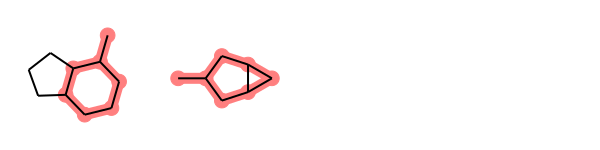

In [59]:
draw_mols((a_methyl_bcn, b_methyl_bch), padding=0.3,
          mcs_res=a_bcn_b_bch_res_legacy)

This is another occurrence of the same bug:

In [60]:
trimethyl_2_5_8_bcn = Chem.MolFromSmiles("CC1CC(C)CC2CC(C)CC12")

In [61]:
dimethyl_3_6_bch = Chem.MolFromSmiles("C1C(C)CC2C(C)C12")

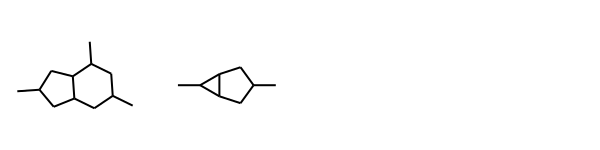

In [62]:
draw_mols((trimethyl_2_5_8_bcn, dimethyl_3_6_bch))

In [63]:
tmbcn_dmbch_res = rdFMCS.FindMCS(
    (trimethyl_2_5_8_bcn, dimethyl_3_6_bch),
    ringMatchesRingOnly=True, completeRingsOnly=True)

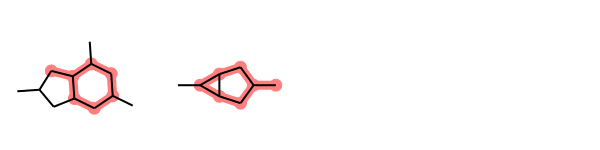

In [64]:
draw_mols((trimethyl_2_5_8_bcn, dimethyl_3_6_bch), mcs_res=tmbcn_dmbch_res)

OK, that's a separate problem, let's go back to the main topic, which is MCS involving condensed ring systems.
If I condense three bonds on the same ring, then the MCS between two methyl-substituted bicyclo[4.3.1.0]decanes includes the whole condensed ring core:

In [65]:
a_methyl_bcd = Chem.MolFromSmiles("CC1CCCC2(C3)CCCC123")

In [66]:
b_methyl_bcd = Chem.MolFromSmiles("C1C(C)CCC2(C3)CCCC123")

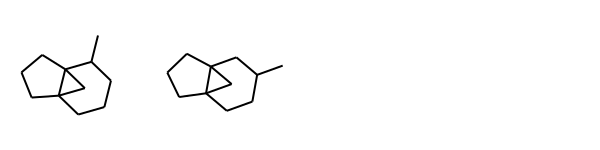

In [67]:
draw_mols((a_methyl_bcd, b_methyl_bcd))

In [68]:
a_methyl_bcd_b_methyl_bcd_res = rdFMCS.FindMCS(
    (a_methyl_bcd, b_methyl_bcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

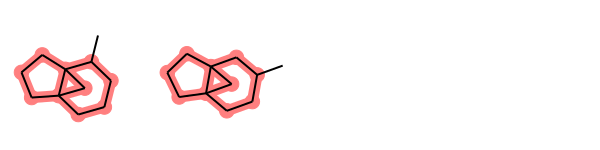

In [69]:
draw_mols((a_methyl_bcd, b_methyl_bcd), mcs_res=a_methyl_bcd_b_methyl_bcd_res)

Here we have yet another occurrence of the ring/non-ring match bug:

In [70]:
a_methyl_bcd_dimethyl_3_6_bch_res = rdFMCS.FindMCS(
    (a_methyl_bcd, dimethyl_3_6_bch),
    ringMatchesRingOnly=True, completeRingsOnly=True)

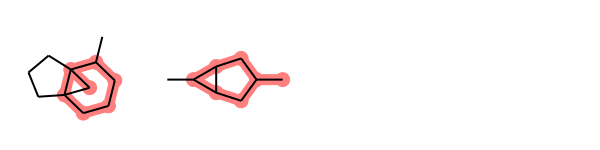

In [71]:
draw_mols((a_methyl_bcd, dimethyl_3_6_bch),
          mcs_res=a_methyl_bcd_dimethyl_3_6_bch_res)

In [72]:
a_methyl_bcn_a_methyl_bcd_res = rdFMCS.FindMCS(
    (a_methyl_bcn, a_methyl_bcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

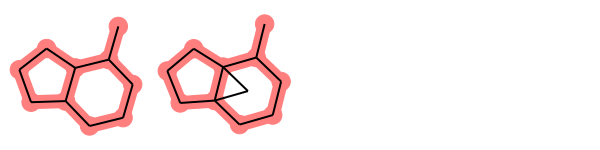

In [73]:
draw_mols((a_methyl_bcn, a_methyl_bcd),
          mcs_res=a_methyl_bcn_a_methyl_bcd_res)

In [74]:
b_methyl_bcn_a_methyl_bcd_res = rdFMCS.FindMCS(
    (b_methyl_bcn, a_methyl_bcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

And another one:

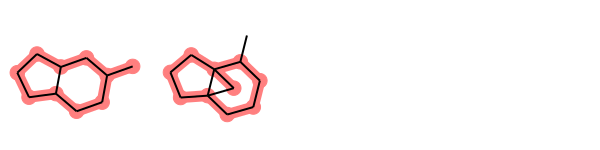

In [75]:
draw_mols((b_methyl_bcn, a_methyl_bcd),
          mcs_res=b_methyl_bcn_a_methyl_bcd_res)

In [76]:
methyl_2_bch = Chem.MolFromSmiles("CC1CCC2CC12")

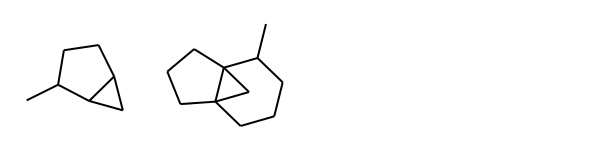

In [77]:
draw_mols((methyl_2_bch, a_methyl_bcd))

In [78]:
methyl_2_bch_a_methyl_bcd_res = rdFMCS.FindMCS(
    (methyl_2_bch, a_methyl_bcd),
    ringMatchesRingOnly=True, completeRingsOnly=True)

As a chemist, here I'd prefer to see bicyclo[3.1.0]hexane as the MCS:

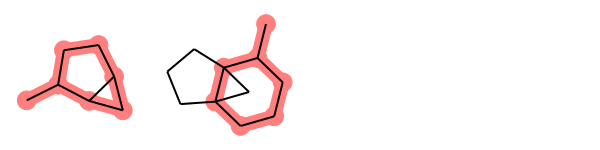

In [79]:
draw_mols((methyl_2_bch, a_methyl_bcd),
          mcs_res=methyl_2_bch_a_methyl_bcd_res)

While writing test cases, I ran into another bug: the MCS between methylcyclopentane and methylcyclohexane is null:

In [80]:
methylcyclopentane = Chem.MolFromSmiles("CC1CCCC1")

In [81]:
methylcyclohexane = Chem.MolFromSmiles("CC1CCCCC1")

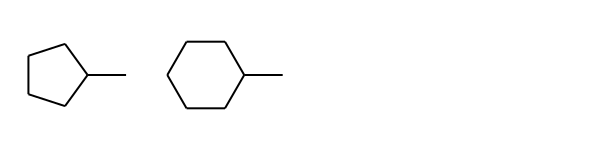

In [82]:
draw_mols((methylcyclopentane, methylcyclohexane))

In [83]:
mcp_mch_res = rdFMCS.FindMCS(
    (methylcyclopentane, methylcyclohexane),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [84]:
mcp_mch_res.numAtoms

0

In [85]:
mcp_mch_res.numBonds

0

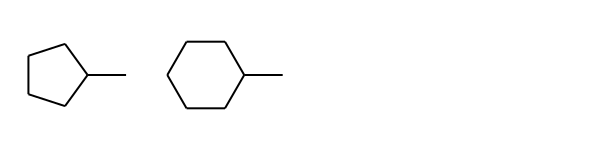

In [86]:
draw_mols((methylcyclopentane, methylcyclohexane), mcs_res=mcp_mch_res)

However, when I repeat the calculation with Andrew Dalke's original MCS implementation, the correct MCS is returned:

In [87]:
mcp_mch_res_legacy = MCS.FindMCS(
    (methylcyclopentane, methylcyclohexane),
    ringMatchesRingOnly=True, completeRingsOnly=True)

__main__:3: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.


In [88]:
mcp_mch_res_legacy.numAtoms

2

In [89]:
mcp_mch_res_legacy.numBonds

1

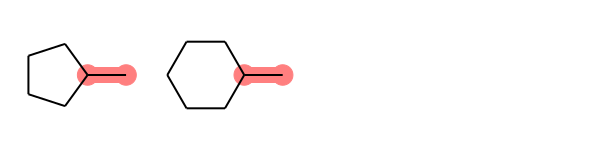

In [90]:
draw_mols((methylcyclopentane, methylcyclohexane), mcs_res=mcp_mch_res_legacy)

Interestingly, when I compute the MCS between ethylcyclopentane and ethylcyclohexane I get the correct MCS from `rdFMCS`:

In [91]:
ethylcyclopentane = Chem.MolFromSmiles("CCC1CCCC1")

In [92]:
ethylcyclohexane = Chem.MolFromSmiles("CCC1CCCCC1")

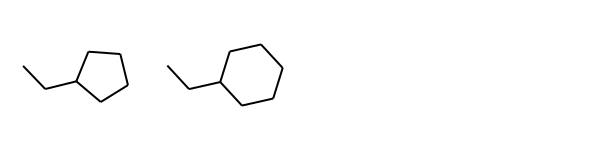

In [93]:
draw_mols((ethylcyclopentane, ethylcyclohexane))

In [94]:
ecp_ech_res = rdFMCS.FindMCS(
    (ethylcyclopentane, ethylcyclohexane),
    ringMatchesRingOnly=True, completeRingsOnly=True)

In [95]:
ecp_ech_res.numAtoms

3

In [96]:
ecp_ech_res.numBonds

2

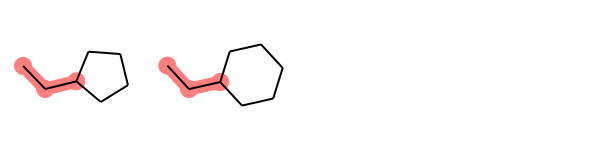

In [97]:
draw_mols((ethylcyclopentane, ethylcyclohexane), mcs_res=ecp_ech_res)

And so I do when computing the MCS between acetaldehyde and propene:

In [98]:
acetaldehyde = Chem.MolFromSmiles("CC=O")

In [99]:
propene = Chem.MolFromSmiles("CC=C")

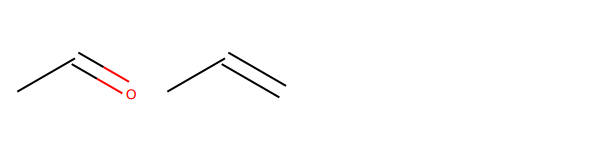

In [100]:
draw_mols((acetaldehyde, propene))

In [101]:
acetaldehyde_propene_res = rdFMCS.FindMCS(
    (acetaldehyde, propene),
    ringMatchesRingOnly=True, completeRingsOnly=True)

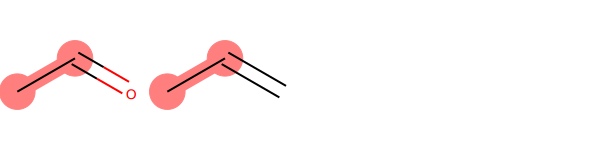

In [102]:
draw_mols((acetaldehyde, propene), mcs_res=acetaldehyde_propene_res)